# $\ell_1$ Recovery and Mutual Coherence

This notebook explains the linear inverse problem

$$
A=[a_1,a_2,\ldots,a_N],\qquad \mu(A)=\max_{i\neq j}|a_i^\top a_j|
$$

and its connection to sparse recovery with $\ell_1$ methods.

We focus on:

- **Exact sparse recovery (noiseless):**
  $$\min_x \|x\|_1\ \text{s.t.}\ Ax=y$$
- **Stable sparse recovery (noisy):**
  $$\min_x \tfrac12\|y-Ax\|_2^2+\lambda\|x\|_1$$

with the mutual-coherence-based sufficient condition

$$
\|x^\star\|_0 < \frac12\left(1+\frac1{\mu(A)}\right).
$$

## 1) Core definitions

Assume columns are normalized, $\|a_i\|_2=1$.

- $\mu(A)$ measures the worst pairwise similarity between columns.
- Smaller $\mu(A)$ means columns are less correlated, which makes sparse identification easier.

For a $k$-sparse signal ($k=\|x^\star\|_0$), a classical sufficient condition for exact recovery by basis pursuit is:

$$
k < \frac12\left(1+\frac1{\mu(A)}\right).
$$

This is **sufficient, not necessary**: recovery can still succeed even when this bound is violated.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from sklearn.linear_model import Lasso

rng = np.random.default_rng(42)


def normalize_columns(A: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(A, axis=0, keepdims=True)
    return A / np.maximum(norms, 1e-12)


def mutual_coherence(A: np.ndarray) -> float:
    G = A.T @ A
    np.fill_diagonal(G, 0.0)
    return float(np.max(np.abs(G)))


def coherence_bound(mu: float) -> float:
    return 0.5 * (1.0 + 1.0 / mu)


def make_dictionary(m: int, n: int, rho: float, seed: int = 0) -> np.ndarray:
    """
    Build a dictionary with controlled correlation between first two atoms.
    rho in [0, 1): larger rho -> more coherent.
    """
    local_rng = np.random.default_rng(seed)
    A = local_rng.standard_normal((m, n))
    A = normalize_columns(A)

    a1 = A[:, 0]
    v = local_rng.standard_normal(m)
    v = v - a1 * (a1 @ v)
    v /= np.linalg.norm(v)

    A[:, 1] = rho * a1 + np.sqrt(max(1.0 - rho**2, 1e-12)) * v
    A = normalize_columns(A)
    return A


def make_sparse_signal(n: int, k: int, seed: int = 0) -> np.ndarray:
    local_rng = np.random.default_rng(seed)
    x = np.zeros(n)
    supp = local_rng.choice(n, size=k, replace=False)
    x[supp] = local_rng.uniform(0.8, 1.2, size=k) * local_rng.choice([-1.0, 1.0], size=k)
    return x


def basis_pursuit_linprog(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Solve min ||x||_1 s.t. A x = y via LP variable split x=u-v, u,v>=0."""
    m, n = A.shape
    c = np.ones(2 * n)
    Aeq = np.hstack([A, -A])
    beq = y
    bounds = [(0, None)] * (2 * n)

    res = linprog(c, A_eq=Aeq, b_eq=beq, bounds=bounds, method="highs")
    if not res.success:
        raise RuntimeError(f"LP failed: {res.message}")

    u = res.x[:n]
    v = res.x[n:]
    return u - v


def rel_err(xhat: np.ndarray, xtrue: np.ndarray) -> float:
    denom = np.linalg.norm(xtrue) + 1e-12
    return float(np.linalg.norm(xhat - xtrue) / denom)


## 2) Noiseless problem: $\min\|x\|_1$ s.t. $Ax=y$

We test different dictionary coherences and compare:

- actual sparsity $k=\|x^\star\|_0$,
- theoretical threshold $\frac12(1+1/\mu(A))$,
- numerical recovery error from basis pursuit.


   rho      mu(A)      bound    k      rel_err    success
  0.00     0.6549      1.264    3     1.86e-16       True
  0.40     0.5915      1.345    3     2.76e-16       True
  0.70     0.7000      1.214    3     8.27e-16       True
  0.90     0.9000      1.056    3     1.93e-16       True
  0.97     0.9700      1.015    3     5.06e-16       True


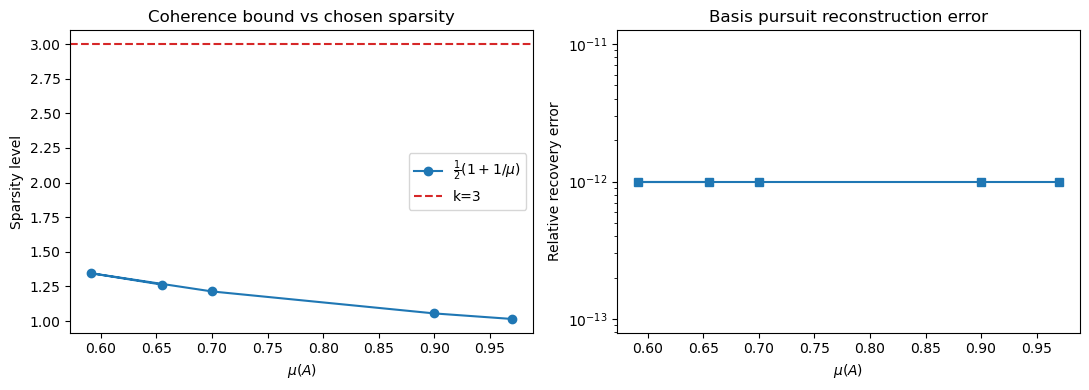

In [3]:
m, n = 25, 40
k = 3
rhos = [0.0, 0.4, 0.7, 0.9, 0.97]

rows = []
for i, rho in enumerate(rhos):
    A = make_dictionary(m, n, rho=rho, seed=100 + i)
    mu = mutual_coherence(A)
    k_bound = coherence_bound(mu)

    x_true = make_sparse_signal(n, k=k, seed=200 + i)
    y = A @ x_true

    x_bp = basis_pursuit_linprog(A, y)
    e = rel_err(x_bp, x_true)
    success = e < 1e-4

    rows.append((rho, mu, k_bound, k, e, success))

print(f"{'rho':>6} {'mu(A)':>10} {'bound':>10} {'k':>4} {'rel_err':>12} {'success':>10}")
for rho, mu, kb, kk, e, s in rows:
    print(f"{rho:6.2f} {mu:10.4f} {kb:10.3f} {kk:4d} {e:12.2e} {str(s):>10}")

mus = [r[1] for r in rows]
bounds = [r[2] for r in rows]
errs = [r[4] for r in rows]

fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].plot(mus, bounds, "o-", label=r"$\frac{1}{2}(1+1/\mu)$")
ax[0].axhline(k, color="tab:red", linestyle="--", label=f"k={k}")
ax[0].set_xlabel(r"$\mu(A)$")
ax[0].set_ylabel("Sparsity level")
ax[0].set_title("Coherence bound vs chosen sparsity")
ax[0].legend()

ax[1].semilogy(mus, np.maximum(errs, 1e-12), "s-")
ax[1].set_xlabel(r"$\mu(A)$")
ax[1].set_ylabel("Relative recovery error")
ax[1].set_title("Basis pursuit reconstruction error")

plt.tight_layout()
plt.show()

## 3) Noisy problem: $\|y-Ax\|_2^2 + \lambda\|x\|_1$

When measurements are noisy, equality constraints are too strict.

Two equivalent viewpoints are common:

- **Penalized (Lasso):**
  $$\min_x \tfrac12\|y-Ax\|_2^2+\lambda\|x\|_1$$
- **Constrained (BPDN):**
  $$\min_x \|x\|_1\ \text{s.t.}\ \|y-Ax\|_2\le \varepsilon$$

As coherence increases, support recovery generally becomes less stable for fixed noise level and regularization.

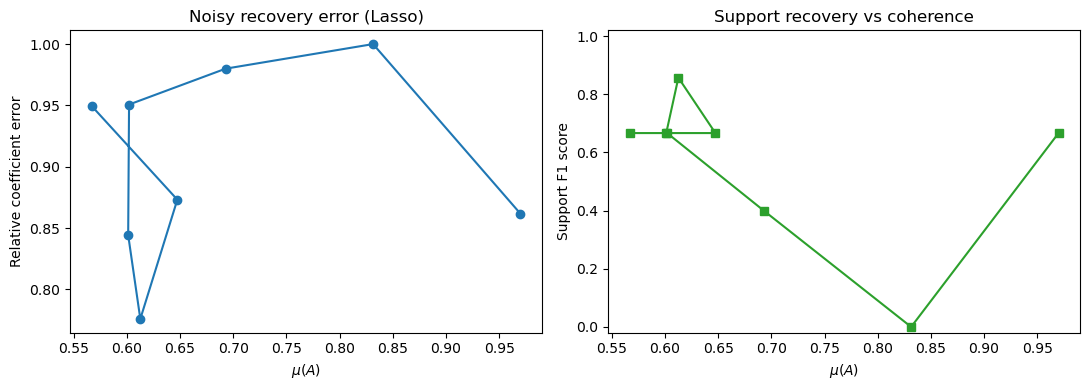

mu(A) values: [0.567 0.647 0.613 0.601 0.602 0.693 0.831 0.97 ]
Lasso relative errors: [0.949 0.873 0.776 0.844 0.951 0.98  1.    0.862]
Support F1 scores: [0.667 0.667 0.857 0.667 0.667 0.4   0.    0.667]


In [4]:
m, n = 30, 50
k = 4
sigma = 0.05
lam = 0.03
rhos = np.linspace(0.0, 0.97, 8)

err_lasso = []
supp_f1 = []
mu_values = []

for i, rho in enumerate(rhos):
    A = make_dictionary(m, n, rho=float(rho), seed=1000 + i)
    mu_values.append(mutual_coherence(A))

    x_true = make_sparse_signal(n, k=k, seed=2000 + i)
    noise = sigma * rng.standard_normal(m)
    y = A @ x_true + noise

    model = Lasso(alpha=lam, fit_intercept=False, max_iter=20000)
    model.fit(A, y)
    x_hat = model.coef_

    err_lasso.append(rel_err(x_hat, x_true))

    support_true = set(np.where(np.abs(x_true) > 1e-12)[0].tolist())
    support_hat = set(np.where(np.abs(x_hat) > 1e-2)[0].tolist())

    tp = len(support_true & support_hat)
    prec = tp / max(len(support_hat), 1)
    rec = tp / len(support_true)
    f1 = 2 * prec * rec / max(prec + rec, 1e-12)
    supp_f1.append(f1)

fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].plot(mu_values, err_lasso, "o-")
ax[0].set_xlabel(r"$\mu(A)$")
ax[0].set_ylabel("Relative coefficient error")
ax[0].set_title("Noisy recovery error (Lasso)")

ax[1].plot(mu_values, supp_f1, "s-", color="tab:green")
ax[1].set_xlabel(r"$\mu(A)$")
ax[1].set_ylabel("Support F1 score")
ax[1].set_ylim(-0.02, 1.02)
ax[1].set_title("Support recovery vs coherence")

plt.tight_layout()
plt.show()

print("mu(A) values:", np.round(mu_values, 3))
print("Lasso relative errors:", np.round(err_lasso, 3))
print("Support F1 scores:", np.round(supp_f1, 3))

## 4) Takeaways

- Mutual coherence gives an interpretable geometric criterion for sparse identifiability.
- The bound
  $$k<\frac12\left(1+\frac1{\mu(A)}\right)$$
  guarantees exact $\ell_1$ recovery in the noiseless case.
- In noisy settings, $\ell_1$ regularization (Lasso/BPDN) gives stable recovery, but performance degrades as coherence grows.
- In practice, the coherence bound is conservative but useful for design and diagnostics of sensing dictionaries.

---

### Optional exercise

Repeat the experiments for different $m/n$ ratios and observe how that changes both $\mu(A)$ and recovery quality.

## 5) Monte Carlo average (optional)

Single random trials can be noisy. This section repeats the noisy recovery experiment many times per coherence level and reports mean $\pm$ std for:

- relative coefficient error,
- support F1 score.

This gives a smoother picture of how increasing $\mu(A)$ affects recovery stability.

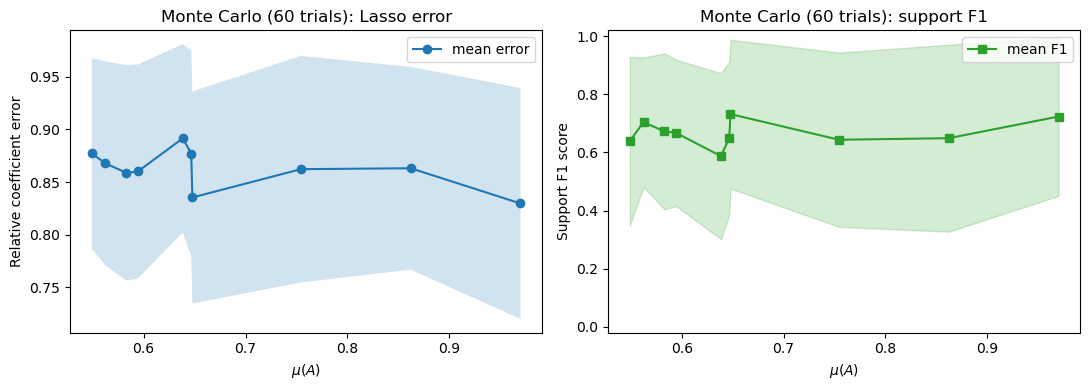

mu(A): [0.549 0.562 0.583 0.594 0.638 0.647 0.648 0.754 0.862 0.97 ]
mean relative error: [0.877 0.868 0.859 0.86  0.892 0.877 0.835 0.862 0.863 0.83 ]
std relative error: [0.091 0.097 0.102 0.102 0.089 0.098 0.101 0.108 0.096 0.11 ]
mean support F1: [0.639 0.704 0.672 0.667 0.588 0.649 0.732 0.644 0.649 0.723]
std support F1: [0.29  0.223 0.268 0.252 0.285 0.263 0.256 0.3   0.322 0.273]


In [6]:
m, n = 30, 50
k = 4
sigma = 0.05
lam = 0.03
n_trials = 60
rhos = np.linspace(0.0, 0.97, 10)

mu_vals = []
err_mean, err_std = [], []
f1_mean, f1_std = [], []

for i, rho in enumerate(rhos):
    A = make_dictionary(m, n, rho=float(rho), seed=3000 + i)
    mu = mutual_coherence(A)
    mu_vals.append(mu)

    trial_err = []
    trial_f1 = []
    for t in range(n_trials):
        x_true = make_sparse_signal(n, k=k, seed=4000 + 100 * i + t)
        noise = sigma * rng.standard_normal(m)
        y = A @ x_true + noise

        model = Lasso(alpha=lam, fit_intercept=False, max_iter=20000)
        model.fit(A, y)
        x_hat = model.coef_

        trial_err.append(rel_err(x_hat, x_true))

        support_true = set(np.where(np.abs(x_true) > 1e-12)[0].tolist())
        support_hat = set(np.where(np.abs(x_hat) > 1e-2)[0].tolist())

        tp = len(support_true & support_hat)
        prec = tp / max(len(support_hat), 1)
        rec = tp / len(support_true)
        f1 = 2 * prec * rec / max(prec + rec, 1e-12)
        trial_f1.append(f1)

    err_mean.append(np.mean(trial_err))
    err_std.append(np.std(trial_err))
    f1_mean.append(np.mean(trial_f1))
    f1_std.append(np.std(trial_f1))

mu_vals = np.array(mu_vals)
err_mean = np.array(err_mean)
err_std = np.array(err_std)
f1_mean = np.array(f1_mean)
f1_std = np.array(f1_std)

order = np.argsort(mu_vals)
mu_plot = mu_vals[order]
err_mean_plot = err_mean[order]
err_std_plot = err_std[order]
f1_mean_plot = f1_mean[order]
f1_std_plot = f1_std[order]

fig, ax = plt.subplots(1, 2, figsize=(11, 4))

ax[0].plot(mu_plot, err_mean_plot, "o-", label="mean error")
ax[0].fill_between(mu_plot, err_mean_plot - err_std_plot, err_mean_plot + err_std_plot, alpha=0.2)
ax[0].set_xlabel(r"$\mu(A)$")
ax[0].set_ylabel("Relative coefficient error")
ax[0].set_title(f"Monte Carlo ({n_trials} trials): Lasso error")
ax[0].legend()

ax[1].plot(mu_plot, f1_mean_plot, "s-", color="tab:green", label="mean F1")
ax[1].fill_between(mu_plot, f1_mean_plot - f1_std_plot, f1_mean_plot + f1_std_plot, color="tab:green", alpha=0.2)
ax[1].set_xlabel(r"$\mu(A)$")
ax[1].set_ylabel("Support F1 score")
ax[1].set_ylim(-0.02, 1.02)
ax[1].set_title(f"Monte Carlo ({n_trials} trials): support F1")
ax[1].legend()

plt.tight_layout()
plt.show()

print("mu(A):", np.round(mu_plot, 3))
print("mean relative error:", np.round(err_mean_plot, 3))
print("std relative error:", np.round(err_std_plot, 3))
print("mean support F1:", np.round(f1_mean_plot, 3))
print("std support F1:", np.round(f1_std_plot, 3))